to start, upload [data_public_reference_data_dev.zip](https://ukplab.github.io/PuzzLing-Machines/data/public_reference_data_dev.zip) (PuzzLing) and [data.zip](https://github.com/nathanchi/modeLing/blob/main/data.zip) (modeLing) to directory

also set api key

In [374]:
import os

os.environ['OPENAI_API_KEY'] = ##

# Process Data

In [337]:
!unzip /content/data_public_reference_data_dev.zip

Archive:  /content/data_public_reference_data_dev.zip
replace c89b677f974124e2456cf62c2833a192925c80b54df0530c8a9a3f890d1e968b.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace 7ee299cd1ed6a85bb2bfb20227d4435883e951fd395cdb6e348c1f39da90eb22.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace c12893345af3b893e10c7636d5ce45021a0b7afec42e7974b0b659d7642d4949.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace 00ef1258e0aca9700298ad1fd2102d08c822be535775b07009cdb236a1e256b4.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace 3ffcecc4d8cdecaf42fc0bd4b847543103bdb651f4f8e3374121cf7ad7e6d61b.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace 796197ea32f0be576def7da35885e34f2355d8c292a2092909a2b6b2a0e1f791.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace da1ab3a436df76b43d6166ae1c2786e2caf5bfceafde5d5e16b741d645928f5f.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace b1886646ac3f6e86da88a9b743a52e960849f488b9e04c65d7371394d631da61.json? [y]es, [n]o, [A]ll, [N]one, [r]en

In [338]:
ls = ['00ef1258e0aca9700298ad1fd2102d08c822be535775b07009cdb236a1e256b4.json',
'3ffcecc4d8cdecaf42fc0bd4b847543103bdb651f4f8e3374121cf7ad7e6d61b.json',
'43114f85daf1648b417f9fbb6b6eb7b30a4188d2df7dbbc81423e966f602dfc7.json',
'796197ea32f0be576def7da35885e34f2355d8c292a2092909a2b6b2a0e1f791.json',
'7ee299cd1ed6a85bb2bfb20227d4435883e951fd395cdb6e348c1f39da90eb22.json',
'a77783c1f82d55853b0be65f7402fa9995668d77ca996707de4a9b2b249acd78.json',
'b1886646ac3f6e86da88a9b743a52e960849f488b9e04c65d7371394d631da61.json',
'c12893345af3b893e10c7636d5ce45021a0b7afec42e7974b0b659d7642d4949.json',
'c89b677f974124e2456cf62c2833a192925c80b54df0530c8a9a3f890d1e968b.json',
'da1ab3a436df76b43d6166ae1c2786e2caf5bfceafde5d5e16b741d645928f5f.json']

In [339]:
data = []
for f in ls:

    with open('/content/'+f, 'r') as fil:
      data.append(dict(eval(fil.read())))

In [340]:
og_pset = []

for s in data:
  src = s['source_language'].strip()
  tgt = s['target_language'].strip()

  d = {}
  d[src] = [c[0] for c in s['train']]
  d[tgt] = [c[1] for c in s['train']]

  d[src + "_test"] = [c[0] for c in s['test']]
  d[tgt + "_test"] = [c[1] for c in s['test']]

  og_pset.append(d)

# Generate Translations

In [341]:
!pip install -U deep-translator
from deep_translator import GoogleTranslator

In [342]:
def translate_chunk(langs, train_chunk, test_chunk):
  results = []

  for lang in langs:

    train_translations, test_translations = [], []
    for s in train_chunk:
        train_translations.append(GoogleTranslator(source='en', target=lang).translate(s))
    for s in test_chunk:
        test_translations.append(GoogleTranslator(source='en', target=lang).translate(s))

    results.append((lang, train_translations, test_translations))

  return results

def generate_translations(problemset, langs):

    tasks = []
    for s in problemset:

      train_chunk = s['english']
      test_chunk = s['english_test']
      tasks.append(translate_chunk(langs, train_chunk, test_chunk))

    all_translations = tasks

    for s, translations in zip(problemset, all_translations):
        for lang, train, test in translations:
            s[lang] = train
            s[lang + "_test"] = test

    return problemset

# Pair off + Generate Augmentations

In [343]:
from itertools import combinations

def pair_off(problemset):

  out = []

  for problem in problemset:
    langs = [c for c in problem.keys() if "_test" not in c]
    pairs = list(combinations(langs, 2))

    for pair in pairs:
      out.append({
          "source_language": pair[0],
          "target_language": pair[1],
          "train": list(zip(problem[pair[0]], problem[pair[1]])),
          "test": list(zip(problem[pair[0]+"_test"], problem[pair[1]+"_test"]))})

  return out

# Symbolize Corruption

In [344]:

# method 2
import random
import re
def symbolize(sents, test_sents):

  alphabet = list(set([char.lower() for char in [p for xs in sents + test_sents for p in xs]]))
  symbols = [c for c in "qwertyuiopasdfghjklzxcvbnmáâæàåãäçéêèðëíîìïñóôòøõößþúûùüýÿ"][:len(alphabet)]
  random.shuffle(symbols)



  mapping = dict(zip(alphabet, symbols))

  for x in [c for c in "!#$%&'()*+,-./:;<=>?@[\]^_`{|}~ "]:
    mapping[x] = x

  return ["".join([mapping[a.lower()] for a in w]) for w in sents], ["".join([mapping[a.lower()] for a in w]) for w in test_sents]

# Tune / Train

In [345]:

def formatFTPrompt(data, dir=">"):

  if dir == ">":

    prompt = "\n".join([c[0] + " > " + c[1] for c in data['train']])

    prompt += "\n"

    prompt += "\n".join([c[0] + " > " for c in data['test']])


    ans = "\n".join([c[1] for c in data['test']])

  if dir == "<":

    prompt = "\n".join([c[1] + " > " + c[0] for c in data['train']])

    prompt += "\n"

    prompt += "\n".join([c[1] + " > " for c in data['test']])


    ans = "\n".join([c[0] for c in data['test']])


  return {"messages": [{"role": "system", "content": "You are a few-shot translator"}, {"role": "user", "content": prompt}, {"role": "assistant", "content": ans}]}


In [346]:

def finetune(path, model):

  from openai import OpenAI
  client = OpenAI()


  f = client.files.create(
    file=open(path, "rb"),
    purpose="fine-tune"
  )

  m = client.fine_tuning.jobs.create(
  training_file=f.id,
  model=model
  )

In [347]:

def formatTestPrompt(data):

  prompt_1 = "\n".join([c[0] + " > " + c[1] for c in data['train']])

  prompt_1 += "\n"

  prompt_1 += "\n".join([c[0] + c[1] for c in data['test'] if c[2] == ">"])


  prompt_2 = "\n".join([c[1] + " > " + c[0] for c in data['train']])

  prompt_2 += "\n"

  prompt_2 += "\n".join([c[0] + c[1] for c in data['test'] if c[2] == "<"])

  return prompt_1, prompt_2, len([c[0] + c[1] for c in data['test'] if c[2] == ">"]), len([c[0] + c[1] for c in data['test'] if c[2] == "<"])

# Eval

In [348]:
# !unzip -P linguisticreasoning /content/dataset.zip -d /content/ling

In [349]:
!unzip -P modeling /content/data.zip -d /content/modeling

Archive:  /content/data.zip
replace /content/modeling/final_modeLing.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [350]:
data = []

with open("/content/modeling/final_modeLing.json",'r') as f:
  data = eval(f.read())

In [351]:

def format_modeLing(data):

  src = data['data'][0].split("\n")[0].split(":")[0]
  tgt = data['data'][0].split("\n")[1].split(":")[0]

  sents = [(x.split("\n")[0].split(":")[1],x.split("\n")[1].split(":")[1]) for x in data['data']]

  q1 = [x.split(":")[1] for x in data['questions'] if x.split(":")[0] == src]
  q2 = [x.split(":")[1] for x in data['questions'] if x.split(":")[0] == tgt]

  a1 = [x.split(":")[1] for x in data['answers'] if x.split(":")[0] == tgt]
  a2 = [x.split(":")[1] for x in data['answers'] if x.split(":")[0] == src]

  return sents, q1, q2, a1, a2



def format_modeLing_prompts(sents, q1, q2, a1, a2):

  prompt_1 = "\n".join([c[0] + " > " + c[1] for c in sents])

  prompt_1 += "\n"

  prompt_1 += "\n".join([c + " > " for c in q1])


  prompt_2 = "\n".join([c[1] + " > " + c[0] for c in sents])

  prompt_2 += "\n"

  prompt_2 += "\n".join([c + " > " for c in q2])

  return prompt_1, prompt_2


In [352]:

def postprocess_answer(answer):

  ret = []

  for ans in answer.split("\n"):
    if ans not in [" ", ""]:
      if ">" in ans:
        ans = ans.split(">")[1]

      ret.append(ans.strip())

  return ret

def getAnswers(test_prompt_1, test_prompt_2, t1, t2,
               output_spef = "", model = "ft:gpt-3.5-turbo-0125:personal::B3WxHG8u"):

  t1_preds, t2_preds = "",""
  if t1 > 0:
    t1_preds = getCompletion(test_prompt_1, output_spef, model)

  if t2 > 0:
    t2_preds = getCompletion(test_prompt_2, output_spef, model)

  return postprocess_answer(t1_preds), postprocess_answer(t2_preds)


In [353]:
from openai import OpenAI
client = OpenAI()

def getCompletion(prompt, output_spef, model):
  completion = client.chat.completions.create(
    model=model,
    messages=[
      {"role": "system", "content": "You are a few-shot translator"},
      {"role": "user", "content": prompt + "\n" + output_spef}
    ]
  )
  return completion.choices[0].message.content

In [391]:

def getFullPreds(models):

  d = []
  for problem in data['problems']:

    res = {}

    sents, q1, q2, a1, a2 = format_modeLing(problem)

    src_tgt_prompt, tgt_src_prompt = format_modeLing_prompts(sents, q1, q2, a1, a2)

    res['sents'] = sents
    res['q >'] = q1
    res["q <"] = q2
    res["a >"] = a1
    res["a <"] = a2

    res['context >'] = src_tgt_prompt
    res['context <'] = tgt_src_prompt

    for m in models:
      model_path = models[m]

      output_spef = ""

      if model_path[0] != "f":
        output_spef = "Translate the untranslated sentences. Give one translation per line."

      preds = getAnswers(src_tgt_prompt, tgt_src_prompt, len(q1), len(q2), output_spef=output_spef, model=model_path)
      res[m + "_pred >"] = preds[0][:len(a1)] + [""] * (len(a1) - len(preds[0]))
      res[m + "_pred <"] = preds[1][:len(a2)]+ [""] * (len(a2) - len(preds[1]))

    d.append(res)

  return d

In [355]:
from collections import Counter
from typing import List, Tuple, Dict
import math
import re


def exact_match(prediction: str, reference: str) -> float:
    """
    Compute exact match score between prediction and reference.
    Returns 1.0 if strings match exactly, 0.0 otherwise.
    """
    return float(prediction.strip() == reference.strip())

def get_char_ngrams(text: str, n: int) -> List[str]:
    """
    Get character n-grams from text.
    """
    return [text[i:i+n] for i in range(len(text)-n+1)]

def chrf(prediction: str, reference: str, n: int = 6, beta: float = 2.0) -> float:
    """
    Compute chrF score between prediction and reference.

    Args:
        prediction: Predicted text
        reference: Reference text
        n: Maximum length of character n-grams (default: 6)
        beta: Weight of recall over precision (default: 2.0)
    Returns:
        chrF score between 0.0 and 1.0
    """
    # Initialize variables for storing n-gram matches
    total_precision = 0.0
    total_recall = 0.0

    # Calculate for different n-gram lengths
    for i in range(1, n+1):
        # Get character n-grams
        pred_ngrams = get_char_ngrams(prediction, i)
        ref_ngrams = get_char_ngrams(reference, i)

        # Count n-grams
        pred_counts = Counter(pred_ngrams)
        ref_counts = Counter(ref_ngrams)

        # Calculate matches
        matches = sum((pred_counts & ref_counts).values())

        # Calculate precision and recall for this n-gram length
        if len(pred_ngrams) > 0:
            precision = matches / len(pred_ngrams)
        else:
            precision = 0.0

        if len(ref_ngrams) > 0:
            recall = matches / len(ref_ngrams)
        else:
            recall = 0.0

        total_precision += precision
        total_recall += recall

    # Average precision and recall across n-gram lengths
    avg_precision = total_precision / n
    avg_recall = total_recall / n

    # Handle edge cases
    if avg_precision == 0.0 and avg_recall == 0.0:
        return 0.0

    # Calculate final chrF score
    beta_squared = beta * beta
    score = (1 + beta_squared) * (avg_precision * avg_recall) / \
            (beta_squared * avg_precision + avg_recall)

    return score


def evaluate_corpus(predictions: List[str], references: List[str]) -> Dict[str, float]:
    """
    Evaluate multiple sentences and compute average scores.

    Args:
        predictions: List of predicted sentences
        references: List of reference sentences
    Returns:
        Dictionary containing average scores for each metric
    """
    if len(predictions) != len(references):
        raise ValueError("Number of predictions must match number of references")

    # Initialize score accumulators
    total_scores = {
        'exact_match': 0.0,
        'chrf': 0.0
    }

    # Calculate scores for each sentence pair
    for pred, ref in zip(predictions, references):
        pred = re.sub('[^a-z]','',pred.lower())
        ref = re.sub('[^a-z]','',ref.lower())

        total_scores['exact_match'] += exact_match(pred, ref)
        total_scores['chrf'] += chrf(pred, ref)

    # Calculate averages
    n_sentences = len(predictions)
    avg_scores = {
        metric: score / n_sentences
        for metric, score in total_scores.items()
    }

    return avg_scores

In [356]:

def score(models, d):

  scores = {}


  ## avg scores

  for m in models:

    predictions = [[res[m + "_pred >"], res[m + "_pred <"]] for res in d]
    references = [[res["a >"], res["a <"]] for res in d]

    predictions = [item.strip() for level1 in predictions
                for level2 in level1
                for item in level2]
    references = [item.strip() for level1 in references
                for level2 in level1
                for item in level2]

    avg_scores = evaluate_corpus(predictions, references)

    scores[m + '_preds'] = avg_scores


  ## by dir

  for m in models:

    predictions = [res[m + "_pred >"] for res in d]
    references = [res["a >"] for res in d]

    predictions = [item.strip() for level1 in predictions
                for item in level1]
    references = [item.strip() for level1 in references
                for item in level1]

    avg_scores = evaluate_corpus(predictions, references)

    scores[m + '_preds >'] = avg_scores

    predictions = [res[m + "_pred <"] for res in d]
    references = [res["a <"] for res in d]

    predictions = [item.strip() for level1 in predictions
                for item in level1]
    references = [item.strip() for level1 in references
                for item in level1]

    avg_scores = evaluate_corpus(predictions, references)

    scores[m + '_preds <'] = avg_scores


  ## by diff

  difficulties = [c['difficulty'] for c in data['problems']]
  difficulties = [[c for c in range(len(difficulties)) if difficulties[c] == diff] for diff in [1, 2, 3, 4, 5]]

  for diff, idxs in enumerate(difficulties):

    for m in models:

      predictions = [[res[m + "_pred >"], res[m + "_pred <"]] for res in d]
      references = [[res["a >"], res["a <"]] for res in d]

      predictions = [predictions[i] for i in idxs]
      references = [references[i] for i in idxs]

      predictions = [item.strip() for level1 in predictions
                  for level2 in level1
                  for item in level2]
      references = [item.strip() for level1 in references
                  for level2 in level1
                  for item in level2]

      avg_scores = evaluate_corpus(predictions, references)

      scores[m + '_preds_'+str(diff + 1)] = avg_scores



  return scores

# Pipeline

Get Data

In [357]:
original_dataset = pair_off(generate_translations(og_pset, []))

In [358]:
langs = ['fr', 'it', 'tr', 'ru'] #['fr','zh-CN', 'it', 'tr', 'ru'] ## ?? which ones

pset = generate_translations(og_pset, langs)
augmented_dataset = pair_off(pset)

In [359]:
import copy
augmented_dataset_base = copy.deepcopy(augmented_dataset)

In [360]:
for task in augmented_dataset:

  src_symbolized = symbolize([c[0] for c in task['train']], [c[0] for c in task['test']])
  tgt_symbolized = symbolize([c[1] for c in task['train']], [c[1] for c in task['test']])

  task['train'] = list(zip(src_symbolized[0], tgt_symbolized[0]))
  task['test'] = list(zip(src_symbolized[1], tgt_symbolized[1]))

for task in augmented_dataset_base:

  task['train'] = list(zip([c[0] for c in task['train']], [c[1] for c in task['train']]))
  task['test'] = list(zip([c[0] for c in task['test']], [c[1] for c in task['test']]))

In [361]:
with open("/content/augmented_dataset_symbolized.json", "w") as f:
  f.write(str(augmented_dataset))

with open("/content/augmented_dataset_base.json", "w") as f:
  f.write(str(augmented_dataset_base))

with open("/content/original_dataset.json", "w") as f:
  f.write(str(original_dataset))

In [362]:
symbolized_data = []
with open("/content/augmented_dataset_symbolized.json", "r") as f:
  symbolized_data = list(eval(f.read()))

augmented_data = []
with open("/content/augmented_dataset_base.json", "r") as f:
  augmented_data = list(eval(f.read()))

original_data = []
with open("/content/original_dataset.json", "r") as f:
  original_data = list(eval(f.read()))

In [363]:
len(symbolized_data), len(augmented_data), len(original_data)

(150, 150, 10)

In [364]:
print("symbolized data")
print(symbolized_data[1]['train'][0])

print("augment-only data")
print(augmented_data[1]['train'][0])

print("original data")
print(original_dataset[1]['train'][0])

symbolized data
('rkug ukak fwlokuqwfk rkfdw dwtwdwdw rgfdwlqkl.', "t'çtfâât ãwrq t'áâaaw åsè wdà àâsyâsãd êtkag æçàèmsg.")
augment-only data
('bayi yaɽa ŋunȷaymuŋa baŋgu gurugugu biŋgunman.', "L'alcool rend l'homme qui est toujours blâmé fatigué.")
original data
('Bussen stanser her.', 'The bus stops here.')


Fine-tune

In [228]:
'''
import pandas as pd

# save symbolized data
w_smb = pd.DataFrame([formatFTPrompt(pt,">") for pt in symbolized_data] + [formatFTPrompt(pt,"<") for pt in symbolized_data])
with open("/content/ft_symbolized_data.jsonl", "w") as f:
    f.write(w_smb.to_json(orient="records", lines=True, force_ascii=False))

# save augmented data
w_aug = pd.DataFrame([formatFTPrompt(pt,">") for pt in augmented_data] + [formatFTPrompt(pt,"<") for pt in augmented_data])
with open("/content/ft_augmented_data.jsonl", "w") as f:
    f.write(w_aug.to_json(orient="records", lines=True, force_ascii=False))

# save og data
w_og = pd.DataFrame([formatFTPrompt(pt,">") for pt in original_data] + [formatFTPrompt(pt,"<") for pt in original_data])
with open("/content/original_dataset.jsonl", "w") as f:
    f.write(w_og.to_json(orient="records", lines=True, force_ascii=False))

len(w_smb), len(w_aug), len(w_og) ## GETTING DATA BOTH WAYS -> permutations, not combinations of language pairs
'''

In [365]:

import pandas as pd

# save symbolized data
w_smb = pd.DataFrame([formatFTPrompt(pt,">") for pt in symbolized_data])
with open("/content/ft_symbolized_data.jsonl", "w") as f:
    f.write(w_smb.to_json(orient="records", lines=True, force_ascii=False))

# save augmented data
w_aug = pd.DataFrame([formatFTPrompt(pt,">") for pt in augmented_data])
with open("/content/ft_augmented_data.jsonl", "w") as f:
    f.write(w_aug.to_json(orient="records", lines=True, force_ascii=False))

# save og data
w_og = pd.DataFrame([formatFTPrompt(pt,">") for pt in original_data])
with open("/content/original_dataset.jsonl", "w") as f:
    f.write(w_og.to_json(orient="records", lines=True, force_ascii=False))

len(w_smb), len(w_aug), len(w_og)


(150, 150, 10)

In [368]:
print("PROMPT")
print(list(eval(str(w_og.iloc[0]['messages'])))[1]['content'])
print("\n")
print("EXPECTED RESPONSE")
print(list(eval(str(w_og.iloc[0]['messages'])))[2]['content'])

PROMPT
bayi yaɽa ŋunȷaymuŋa baŋgu gurugugu biŋgunman. > Booze is making the man that is always being blamed tired.
balan yabu bimabanȷalŋaymuŋa baŋgul yaɽaŋgu guliŋgu ŋunȷaɲu. > The strong man is blaming the mother that is always following death adders.
balan waymin bambun baŋgu ȷugaŋgu ȷamiman. > Sugar is making the healthy mother-in-law fat.
bala yila wura baŋgul bargandu biŋgundu guniɲu. > The tired wallaby is searching for the little feather.
balan malayigara baŋgu garandu biŋgunman. > The smoke is making the scorpion tired.
bala gurugu baŋgul ŋumaŋgu munduŋgu dimbaɲu. > The offended father is carrying the booze.
bayi midin baŋgun bimaŋgu malayigaraguninaymuŋagu banȷan. > The death adder that is always searching for scorpions is following the possum.
bayi gubimbulu biŋgun baŋgu gurugugu ȷagunman. > Booze is making the tired doctor fall asleep.
bala garan baŋgul biɲȷiriɲȷu banȷan. > The lizard is following the smoke.
balan duŋan baŋgul yiriɲȷilagu guniɲu. > The dragonfly is searchin

In [367]:
model = "gpt-3.5-turbo"

for path in ['/content/ft_symbolized_data.jsonl', "/content/ft_augmented_data.jsonl","/content/original_dataset.jsonl"]:
  finetune(path, model)


In [376]:
## AFTER FT COMPLETION

model_paths = { "base": model,

                "symb":"ft:gpt-3.5-turbo-0125:personal::B4M8JAr2",
                "og":"ft:gpt-3.5-turbo-0125:personal::B4M0DjgZ",
                "aug":"ft:gpt-3.5-turbo-0125:personal::B4MBEcun"



               # "ft_symb":"ft:gpt-3.5-turbo-0125:personal::B4L7LGDe", # 3 epochs, stop at step ~450 batch_size 1, lr mult 2, final train loss 1.2185
               # "ft_aug":"ft:gpt-3.5-turbo-0125:personal::B4L6ZbLP", # 3 epochs, stop at step ~450 batch_size 1, lr mult 2, final train loss 0.1344
               # "ft_og":"ft:gpt-3.5-turbo-0125:personal::B4KzB1PO", # 10 epochs, stop at step ~100 batch_size 1, lr mult 2, final train loss 0.0167

               # "prev_symb":"ft:gpt-3.5-turbo-0125:personal::B3WxHG8u", # 3 epochs, stop at step ~180 batch_size 1, lr mult 2, final train loss 0.3336

               # "ft_symb_2way":"ft:gpt-3.5-turbo-0125:personal::B4KV5Etq", # 3 epochs, stop at step ~900 batch_size 1, lr mult 2, final train loss 0.8644
               # "ft_aug_2way":"ft:gpt-3.5-turbo-0125:personal::B4KUJrjh", # 3 epochs, stop at step ~900 batch_size 1, lr mult 2,  final train loss 0.0001
               # "ft_og_2way":"ft:gpt-3.5-turbo-0125:personal::B4KCJTJw", # 5 epochs, stop at step 100, batch_size 1, lr mult 2, final train loss 0.5300

               # "ft_aug_step300":"ft:gpt-3.5-turbo-0125:personal::B4KUISNh:ckpt-step-300",
               # "ft_aug_step600":"ft:gpt-3.5-turbo-0125:personal::B4KUIKB6:ckpt-step-600",
               # "ft_symb_step300":"ft:gpt-3.5-turbo-0125:personal::B4KV5uSq:ckpt-step-300",
               # "ft_symb_step600":"ft:gpt-3.5-turbo-0125:personal::B4KV5Inv:ckpt-step-600"
               # "ft_symb_noaug":"",
               }


Eval

In [392]:
d = getFullPreds(model_paths)

with open("/content/modeLing_results.txt", "w") as f:
  f.write(str(d))

In [393]:
scores = score(model_paths, d)

with open("/content/modeLing_scores.txt", "w") as f:
  f.write(str(scores))

In [ ]:
print(scores)

In [ ]:
import seaborn as sns
import pandas as pd
import re

df = pd.DataFrame(scores)

In [ ]:
pd.set_option('display.max_columns', None)

df

In [400]:
diff_cols = [c for c in df.columns if len(re.sub('[^0-9]', '', c)) != 0]
diff_df =  df[diff_cols].T


In [401]:
diff_df['diff'] = diff_df.index.map(lambda x: int(re.sub('[^0-9]', '', x)))
diff_df['model'] = diff_df.index.map(lambda x: x[:-2])

<Axes: xlabel='diff', ylabel='chrf'>

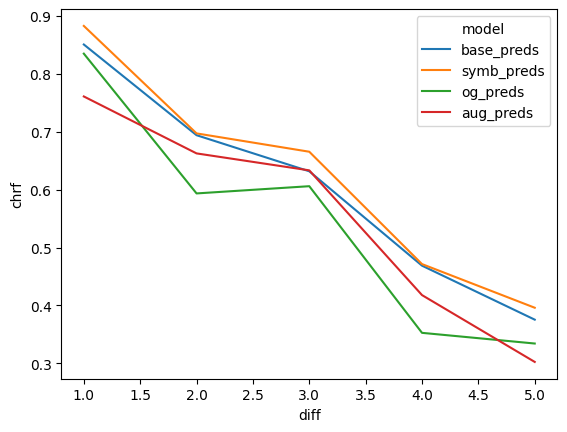

In [390]:
sns.lineplot(data=diff_df, x='diff', y='chrf', hue='model')

<Axes: xlabel='diff', ylabel='exact_match'>

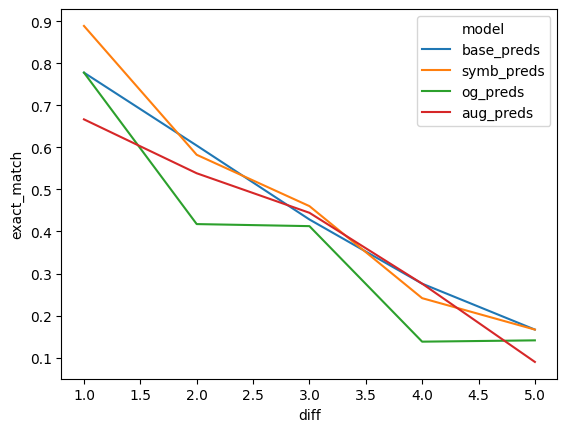

In [387]:
sns.lineplot(data=diff_df, x='diff', y='exact_match', hue='model')

# ignore // dont run!

In [110]:
!python3 /content/evaluate.py ../ /content/ ## FT AUG

'''
Number of translations in total: 89
Number of English -> Foreign translations: 45
Number of Foreign -> English translations: 44
EF_BLEU_SCORE : 7.573885089919696
EF_CHRF_SCORE : 27.503135873005608
EF_CTER_SCORE : 21.071831681497365
EF_EM_SCORE : 6.666666666666667
FE_BLEU_SCORE : 21.033605691913746
FE_CHRF_SCORE : 36.13924836549995
FE_CTER_SCORE : 25.41428594154193
FE_EM_SCORE : 6.8181818181818175
BLEU_SCORE : 14.228128983040353
CHRF_SCORE : 31.772674633339896
CTER_SCORE : 23.218663001069956
EM_SCORE : 6.741573033707865
Evaluation Completed
'''

Number of translations in total: 89
Number of English -> Foreign translations: 45
Number of Foreign -> English translations: 44
EF_BLEU_SCORE : 7.573885089919696
EF_CHRF_SCORE : 27.503135873005608
EF_CTER_SCORE : 21.071831681497365
EF_EM_SCORE : 6.666666666666667
FE_BLEU_SCORE : 21.033605691913746
FE_CHRF_SCORE : 36.13924836549995
FE_CTER_SCORE : 25.41428594154193
FE_EM_SCORE : 6.8181818181818175
BLEU_SCORE : 14.228128983040353
CHRF_SCORE : 31.772674633339896
CTER_SCORE : 23.218663001069956
EM_SCORE : 6.741573033707865
Evaluation Completed


In [ ]:
!python3 /content/EVAL/evaluate.py /content /content ## BASELINE

'''
Number of translations in total: 89
Number of English -> Foreign translations: 45
Number of Foreign -> English translations: 44
EF_BLEU_SCORE : 2.659651922361734
EF_CHRF_SCORE : 27.894373515004013
EF_CTER_SCORE : 15.908108775430446
EF_EM_SCORE : 0.0
FE_BLEU_SCORE : 26.184986600943194
FE_CHRF_SCORE : 40.00523956566664
FE_CTER_SCORE : 30.432074666227205
FE_EM_SCORE : 9.090909090909092
BLEU_SCORE : 14.290154460087404
CHRF_SCORE : 33.881767967017
CTER_SCORE : 23.088496406835585
EM_SCORE : 4.49438202247191
Evaluation Completed
'''

Number of translations in total: 89
Number of English -> Foreign translations: 45
Number of Foreign -> English translations: 44
EF_BLEU_SCORE : 2.659651922361734
EF_CHRF_SCORE : 27.894373515004013
EF_CTER_SCORE : 15.908108775430446
EF_EM_SCORE : 0.0
FE_BLEU_SCORE : 26.184986600943194
FE_CHRF_SCORE : 40.00523956566664
FE_CTER_SCORE : 30.432074666227205
FE_EM_SCORE : 9.090909090909092
BLEU_SCORE : 14.290154460087404
CHRF_SCORE : 33.881767967017
CTER_SCORE : 23.088496406835585
EM_SCORE : 4.49438202247191
Evaluation Completed


In [ ]:
!python3 /content/EVAL/evaluate.py /content/dev /content ## symbol tuned

'''
Number of translations in total: 89
Number of English -> Foreign translations: 45
Number of Foreign -> English translations: 44
EF_BLEU_SCORE : 34.44366300027654
EF_CHRF_SCORE : 61.55933444934497
EF_CTER_SCORE : 52.62853990898678
EF_EM_SCORE : 33.33333333333333
FE_BLEU_SCORE : 15.544867327917105
FE_CHRF_SCORE : 32.465576000228026
FE_CTER_SCORE : 22.83047967444294
FE_EM_SCORE : 11.363636363636363
BLEU_SCORE : 25.100438173492094
CHRF_SCORE : 47.17590330596131
CTER_SCORE : 37.896914624493206
EM_SCORE : 22.47191011235955
Evaluation Completed
'''

Number of translations in total: 89
Number of English -> Foreign translations: 45
Number of Foreign -> English translations: 44
EF_BLEU_SCORE : 34.44366300027654
EF_CHRF_SCORE : 61.55933444934497
EF_CTER_SCORE : 52.62853990898678
EF_EM_SCORE : 33.33333333333333
FE_BLEU_SCORE : 15.544867327917105
FE_CHRF_SCORE : 32.465576000228026
FE_CTER_SCORE : 22.83047967444294
FE_EM_SCORE : 11.363636363636363
BLEU_SCORE : 25.100438173492094
CHRF_SCORE : 47.17590330596131
CTER_SCORE : 37.896914624493206
EM_SCORE : 22.47191011235955
Evaluation Completed
